# Portfolio Optimization

# Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

#Section 1 : Define Tickers and Time Range

# Define the list of tickers

In [ ]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

# Set the end date to today

In [ ]:
end_date = datetime.today()

# Set the start date to 8 years ago

In [ ]:
start_date = end_date - timedelta(days = 8*365)
print(start_date)

2017-06-07 11:12:19.622319


# Section 2 : Download Adjusted Close Prices

# Create an empty DataFrame to store the adjusted close prices

In [ ]:
adj_close_df = pd.DataFrame()

# Download the close prices for each ticker

In [ ]:
for ticker in tickers:
    data = yf.download(tickers, start = start_date, end = end_date, auto_adjust = False)
    adj_close_df = data['Adj Close']



[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


# Display the DataFrame

In [ ]:
print(adj_close_df)

Ticker            BND         GLD         QQQ         SPY         VTI
Date                                                                 
2017-06-07  65.087242  122.449997  135.643967  213.708618  109.681129
2017-06-08  65.039650  121.650002  135.785889  213.813889  109.874046
2017-06-09  64.984070  120.540001  132.390472  213.489380  109.786385
2017-06-12  64.968224  120.360001  131.681198  213.445511  109.768829
2017-06-13  64.984070  120.480003  132.749893  214.489227  110.312538
...               ...         ...         ...         ...         ...
2025-05-29  72.390457  305.609985  519.929993  590.049988  290.119995
2025-05-30  72.529999  303.600006  519.109985  589.390015  289.880005
2025-06-02  72.370003  311.670013  523.210022  592.710022  291.359985
2025-06-03  72.290001  308.910004  527.299988  596.090027  293.369995
2025-06-04  72.739998  310.899994  528.770020  595.929993  293.339996

[2010 rows x 5 columns]


## Section 3 : Calculate Lognormal Returns

# Calculate the lognormal returns for each ticker

In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

# Drop any missing values

In [ ]:
log_returns = log_returns.dropna()

# Section 4 : Calculate Covariance Matrix

# Calculate the covariance matricx using annualized log returns





In [ ]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

Ticker       BND       GLD       QQQ       SPY       VTI
Ticker                                                  
BND     0.003518  0.002866  0.002081  0.001736  0.001852
GLD     0.002866  0.020894  0.003660  0.002642  0.002778
QQQ     0.002081  0.003660  0.057536  0.043445  0.044059
SPY     0.001736  0.002642  0.043445  0.037530  0.038117
VTI     0.001852  0.002778  0.044059  0.038117  0.039016


# Section 5 : Define Portfolio Performance Metrics

# Calculate the portfolio standard deviation



This line of code calculates the portfolio variance, which is a measure of the risk associated with a portfolio of assets. It represents the combined volatility of the assets with each other.

In [ ]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Calculate the expected return

*Key Assumption : Expected returns are based on historical returns

In [ ]:
def expected_returns (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

# Calculate the Sharpe Ratio

In [ ]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_returns (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

# Section 6 : Portfolio Optmization

# Set the risk-free rate

In [ ]:
risk_free_rate = 0.04

In [ ]:
# Install the fredapi library
!pip install fredapi

from IPython import get_ipython
from IPython.display import display

In [ ]:
from fredapi import fred

# Replace 'your_api_key' with your actual FRED API key
fred = fred.Fred(api_key = '68cc8affa24004d2fc9acaea479c21dc')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# Set the risk-free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.044199999999999996


# Define the function to minimize (negative Sharpe Ratio)

In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value of a function

In [ ]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Set the constraints and bounds

Constraints are conditions that must be met by th solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must be equal to 1. The constarints variable is a dictionery with two keys: 'type' and 'fun'. 'type' is set to 'eq' which meaans "equality constraint", and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equals 1.


Bounds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight should be between 0 and 1.

In [ ]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1 })
bounds = [(0, 0.4) for _ in range(len(tickers))]

# Set the initial weights

In [ ]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


# Optimize weights to maximize the Sharpe Ratio

'SLSQP' stands for Sequential Least Squares Quadratic Programming, which is a numerical optimization technique suitable for solving nonlinear optimization problem.

In [ ]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bounds)


# Get the optimal weights

In [ ]:
optimal_weights = optimized_results.x

# Section 7 : Analyze the Optimal Portfolio

# Display analytics of the optimal portfolio

In [ ]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_returns(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected_Annual_Return: {optimal_portfolio_return:.4f}")
print(f"Expected_Volatlity: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe_Ratio: {optimal_sharpe_ratio:.4f}")


Optimal Weights:
SPY: 0.0000
BND: 0.4000
GLD: 0.4000
QQQ: 0.2000
VTI: 0.0000

Expected_Annual_Return: 0.1407
Expected_Volatlity: 0.1503
Sharpe_Ratio: 0.6422


# Dislay the final portfolio in a plot

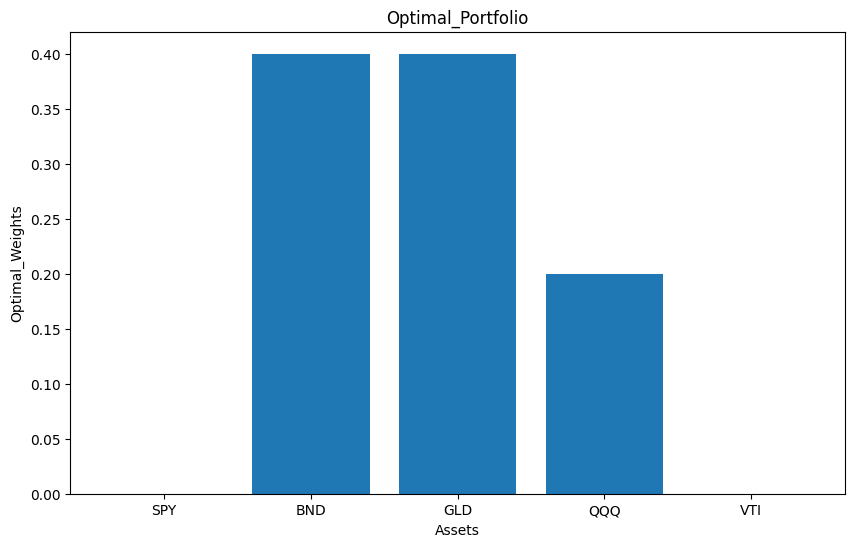

In [ ]:
# Import the required library
import matplotlib.pyplot as plt

# Create a bar chart of the optimal weights
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

# Add labels and a title
plt.xlabel('Assets')
plt.ylabel('Optimal_Weights')
plt.title('Optimal_Portfolio')

# Display the chart
plt.show()
